# Explaining Audio classification blackbox models with Feature Attribution

### Notebook 1: XAI for Affective Computing (SoSe2024)

Intro: In this notebook you will attempt to generate SHAP explanations for predictions of SER model based on Mel-spectrogram features

### Part 0: Import necessary libraries

In [1]:
import matplotlib.pyplot as plt    #!pip install matplotlib
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# To play the audio files
from IPython.display import Audio
import keras
import pandas as pd
import numpy as np
import seaborn as sns 


2024-06-17 12:27:11.002099: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-17 12:27:11.003061: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 12:27:11.011546: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 12:27:11.081470: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 12:27:13.083768: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

# Load the data

In [2]:
data = pd.read_csv('speech_features.csv')
data.head()

,time_step0,time_step1,time_step2,time_step3,time_step4,time_step5,time_step6,time_step7,time_step8,time_step9,...,time_step119,time_step120,time_step121,time_step122,time_step123,time_step124,time_step125,time_step126,time_step127,labels
0,3.567070,0.044534,0.001252,0.000239,0.000243,0.003268,0.017687,0.257522,0.651980,1.289745,...,0.000679,0.000720,0.001191,0.001433,0.002023,0.008617,0.006640,0.003226,0.000118,angry
1,3.573328,0.046764,0.003103,0.001712,0.002607,0.005051,0.019660,0.262473,0.658310,1.295179,...,0.002572,0.002559,0.003121,0.003181,0.003836,0.010527,0.008518,0.005046,0.001995,angry
2,0.000199,0.000038,0.000088,0.000075,0.000232,0.016628,0.064284,0.170988,0.144401,0.076752,...,0.000013,0.000020,0.000019,0.000022,0.000020,0.000034,0.000060,0.000041,0.000002,happy
3,0.000539,0.000381,0.000377,0.000397,0.000621,0.017546,0.065297,0.170199,0.142157,0.076901,...,0.000385,0.000365,0.000381,0.000371,0.000376,0.000382,0.000437,0.000406,0.000374,happy
4,0.000553,0.000054,0.000014,0.000011,0.000087,0.006632,0.021300,0.132629,0.247925,1.605858,...,0.000355,0.000327,0.000407,0.000597,0.001652,0.001219,0.001134,0.000591,0.000061,happy


In [3]:
# Prepare data
X = data.iloc[: ,:-1].values
Y = data['labels'].values

# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2160, 128, 1), (2160, 8), (720, 128, 1), (720, 8))

# Load pretrained CNN model

In [4]:
# The model weights (that are considered the best) can be loaded as -
model_path = 'trained_model/Speech_CNN.h5'
model = keras.models.load_model(model_path)

2024-06-17 12:27:21.193198: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-17 12:27:21.194898: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-17 12:27:21.206356: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required l

## Model's Prediction on test data

In [5]:
# Perform prediction
predictions = model.predict(x_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [6]:
y_pred = encoder.inverse_transform(predictions)

y_test = encoder.inverse_transform(y_test)

In [7]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.90      0.86      0.88        96
        calm       0.70      0.89      0.78       100
     disgust       0.68      0.80      0.73        99
        fear       0.80      0.73      0.76        90
       happy       0.88      0.66      0.75       105
     neutral       0.54      0.65      0.59        48
         sad       0.81      0.71      0.76       103
    surprise       0.80      0.77      0.79        79

    accuracy                           0.77       720
   macro avg       0.76      0.76      0.76       720
weighted avg       0.78      0.77      0.77       720



# TASK 1: visualization

In [8]:
feature_names = data.columns.drop('labels')
class_names = data['labels'].unique()

Text(0, 0.5, 'Emotions')

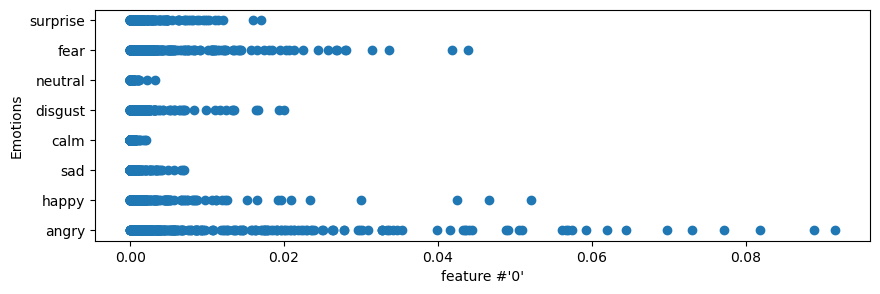

In [9]:
# plot1: explore one feature

plt.figure(figsize=(10,3))
plt.scatter(data['time_step118'], data['labels'])
plt.xlabel("feature #'0'")
plt.ylabel("Emotions")

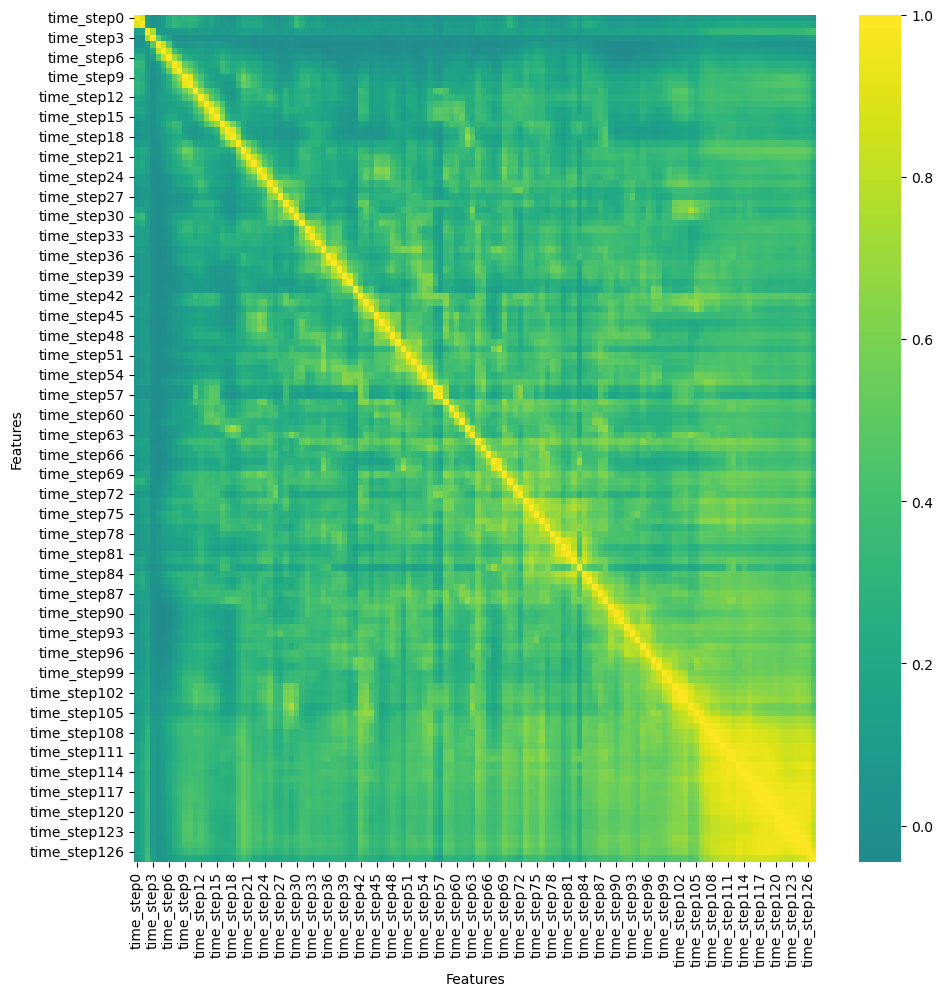

In [10]:
# Correlation heatmap
Features = data.drop(labels='labels', axis=1)
labels = data["labels"]
corr_matrix = Features.corr()


plt.figure(figsize=(11, 11))
sns.heatmap(corr_matrix, 
            cmap="viridis",
            center=0,
            fmt='.lg')
plt.xlabel('Features')
plt.ylabel('Features')

plt.show()

### Part 1: Explanations of Spectrogram

#### TASK 1: Implement SHAP

In [11]:
import shap
shap.initjs()

/home/nasr/anaconda3/envs/audio/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
Features = data.drop(labels='labels', axis=1)
labels = data["labels"]
print(len(Features))

2880


In [13]:
# Use an appropriate masker
F1 = Features[0:4]
masker = shap.maskers.Independent(Features.sample(10))

In [14]:
Explainer = shap.Explainer(model, masker=masker)
shap_values = Explainer(F1)

In [15]:
# Plot the SHAP values: Generate the spectrogram back
shap_values.shape

(4, 128, 8)

In [16]:
shap_values_array = shap_values.values

### Summary Plot

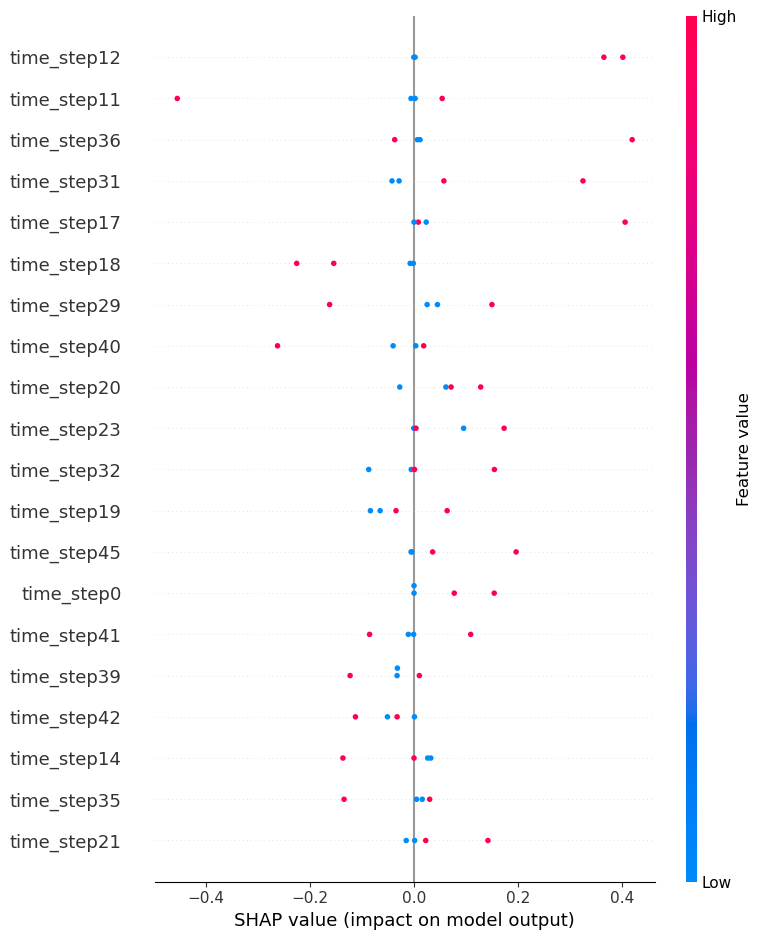

In [17]:
# Create a summary plot for a specific class, e.g., class 0
class_index = 0
shap.summary_plot(shap_values[:, :, class_index], F1)

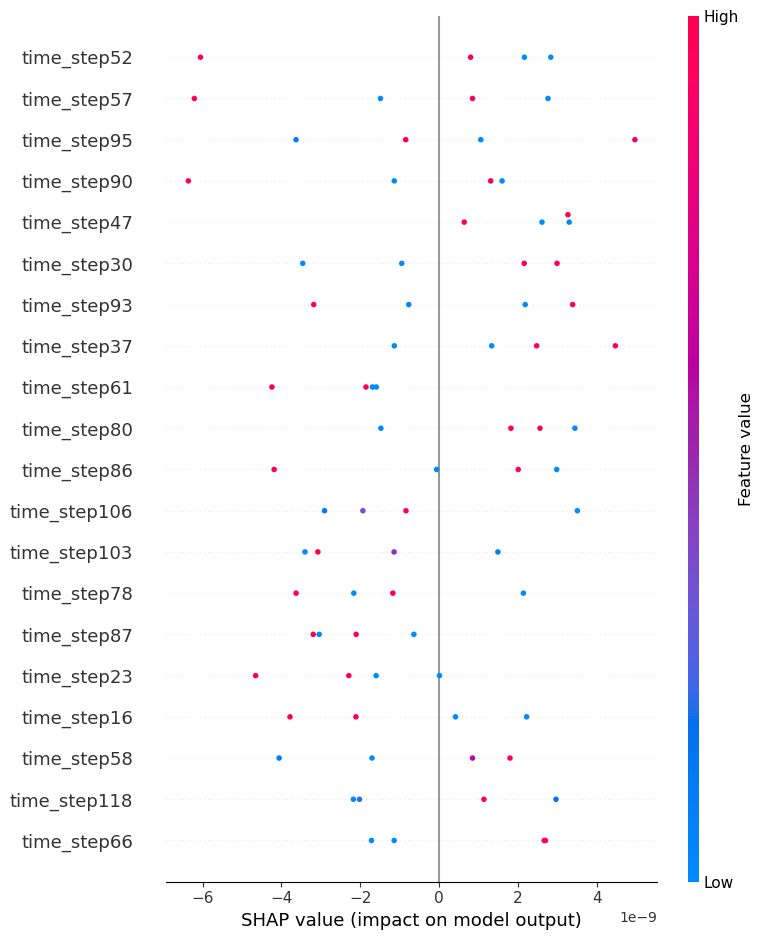

In [18]:
# Average SHAP values impact on the model's predction
average_shap_values = np.mean(shap_values_array, axis=2)
shap.summary_plot(average_shap_values, F1)

### Bar Plot



In [19]:
x = data[0:10]
X = x.drop(labels='labels', axis=1)

In [20]:
# Create a dependence plot for a specific feature and class
feature_name = '0'  # feature you are interested in
class_index = 0  # Index of the class you want to visualize


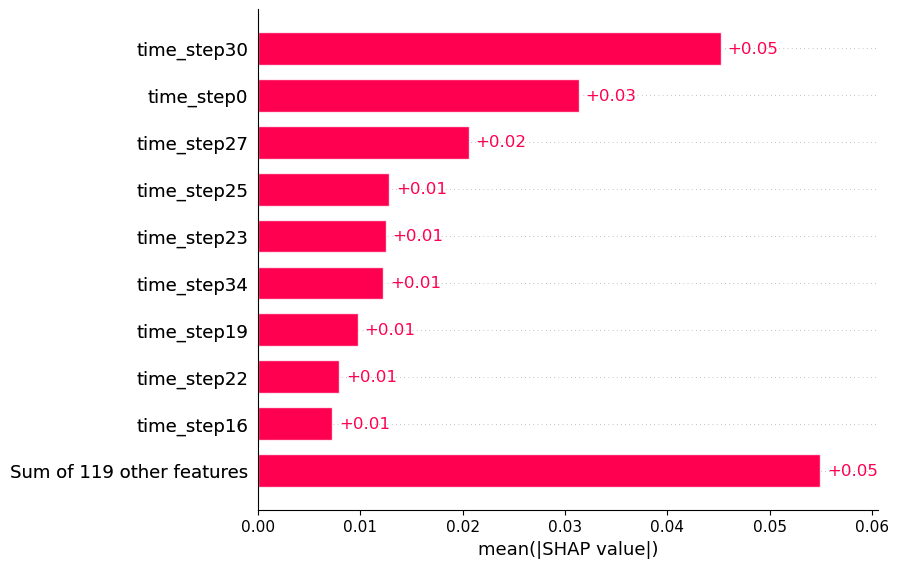

In [21]:
class_index = 2
shap.plots.bar(shap_values[:, :, class_index], max_display= 10)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


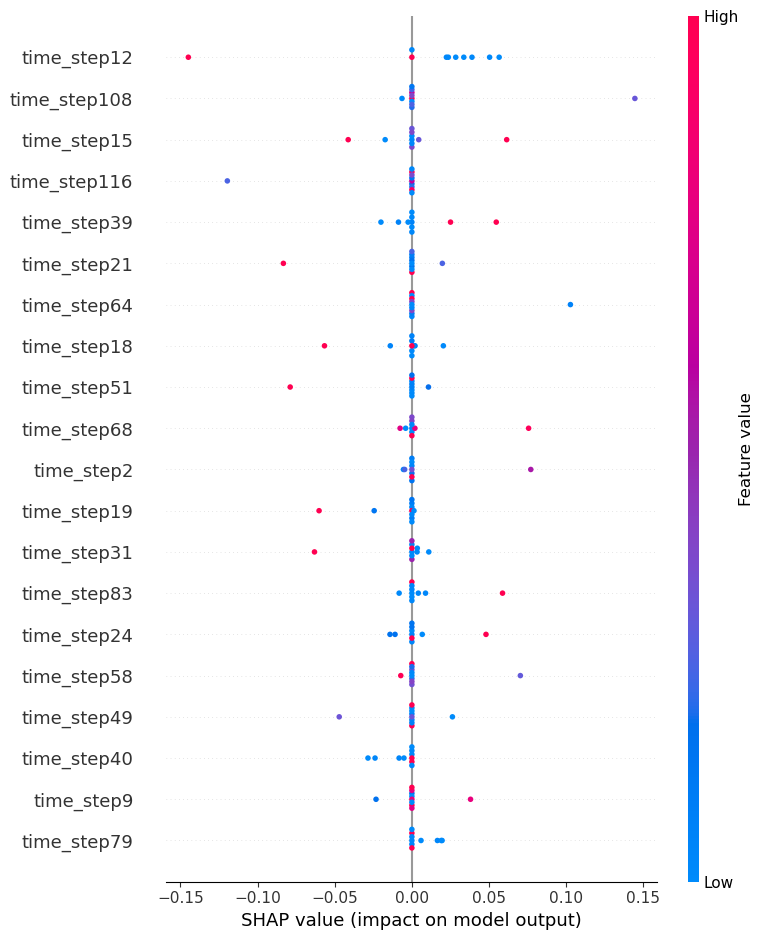

In [22]:
# Features impact on one class e.g: index 3
explainer = shap.KernelExplainer(model, X)
shap_values = explainer.shap_values(X, nsamples=128)
shap.summary_plot(shap_values[:,:,3], X, show=False, class_names=class_names)